In [1]:
# importons les librairies dont nous avons besoin.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-muted')
%matplotlib inline
import math
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [2]:
data = pd.read_csv("clean_data.csv")
save = data

In [3]:
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_TIME,ARR_TIME,ARR_DELAY_NEW,AIR_TIME,DEP_0_280,ARR_0_220,AIR_0_360,DEP_0_280_TIME,ARR_0_220_TIME,AIR_0_360_TIME
0,1,1,5,N537AS,821,14057,12982,616,874,0.0,359.0,0,0,0,616,874,359.0
1,1,1,5,N592AS,822,13830,14057,1300,279,0.0,283.0,0,0,1,1300,279,0.0
2,1,1,5,N531AS,823,14893,13830,573,795,0.0,327.0,0,0,1,573,795,0.0
3,1,1,5,N531AS,823,14747,14893,381,499,0.0,87.0,0,0,1,381,499,0.0
4,1,1,5,N557AS,826,12758,13796,975,1362,0.0,250.0,0,0,1,975,1362,0.0


Convertissons tour à tour les variables de notre dataset en dummies et regardons les effets que cela a sur sa taille et sur nos prédictions. Afin d'effectuer nos tests dans les mêmes conditions fixons le random state de notre split à 0.

In [4]:
all_columns = ["FL_NUM", 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH", "TAIL_NUM"]
columns = []
for column in all_columns:
    data = save
    columns.append(column)
    data = pd.get_dummies(data, columns=columns)
    data = data.drop(columns=list(set(all_columns) - set(columns)), axis=1)
    print(data.shape)
    xtrain, xtest, ytrain, ytest = train_test_split(data.loc[:, data.columns != 'ARR_DELAY_NEW'], data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)
    regr = LinearRegression()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    print("Mean squared error: %.2f"% math.sqrt(mean_squared_error(ytest, ypred)))

(165641, 757)
Mean squared error: 6053423.78
(165641, 825)
Mean squared error: 3148943.61
(165641, 893)
Mean squared error: 19.65
(165641, 905)
Mean squared error: 19.59
(165641, 912)
Mean squared error: 19.58
(165641, 943)
Mean squared error: 19.57
(165641, 1108)
Mean squared error: 19.57


Les meilleurs résultats sont obtenus avec 943 colonnes lorsque toutes nos variables ont été utilisées sauf TAIL_NUM.
Analysons les coefficients afin de comprendre ce qui peut influer sur la prédiction de nos retards.

In [5]:
xtrain.head()

,DEP_TIME,ARR_TIME,AIR_TIME,DEP_0_280,ARR_0_220,AIR_0_360,DEP_0_280_TIME,ARR_0_220_TIME,AIR_0_360_TIME,FL_NUM_1,...,TAIL_NUM_N779AS,TAIL_NUM_N788AS,TAIL_NUM_N791AS,TAIL_NUM_N792AS,TAIL_NUM_N793AS,TAIL_NUM_N794AS,TAIL_NUM_N795AS,TAIL_NUM_N796AS,TAIL_NUM_N797AS,TAIL_NUM_N799AS
55505,1275,1395,89.0,0,0,1,1275,1395,0.0,0,...,0,0,0,0,0,0,0,0,0,0
60493,454,628,334.0,0,0,1,454,628,0.0,0,...,0,0,0,0,0,0,0,0,0,0
57102,537,690,128.0,0,0,1,537,690,0.0,0,...,0,0,0,0,0,0,0,0,0,0
40725,581,726,304.0,0,0,1,581,726,0.0,0,...,0,0,0,0,0,0,0,0,0,0
64986,450,577,290.0,0,0,1,450,577,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
list(regr.coef_[0][0:15])

[0.4401438556234894,
 0.25387467277806425,
 0.2208849068158672,
 153.97542401490813,
 90.39804518965592,
 111.13182670325295,
 -0.33828591537680097,
 -0.20739422591041645,
 0.30756927106061127,
 38.02522580659736,
 -15.183435249030284,
 -54.00869452012523,
 36.429890580217204,
 53.45539259836068,
 -68.42774090320735]

On voit ici l'importance de nos variables booléennes dont les coefficients sont très élevés. Les numéros de vol semblent également avoir une importance notable ici.

Continuons donc avec ce modèle et regardons s'il est possible de l'améliorer.

In [7]:
save = save.drop(columns=["TAIL_NUM"], axis=1)
data = save
data = pd.get_dummies(data, columns=["FL_NUM", 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH"])
dummies_data = data

# Modèles avec dummies


## Supression des outliers

Essayons maintenant de voir ce que peut apporter la suppression des outliers. 

In [8]:
data = dummies_data
xtrain, xtest, ytrain, ytest = train_test_split(data.loc[:, data.columns != 'ARR_DELAY_NEW'], 
                                                data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)

In [9]:
train = pd.merge(xtrain, ytrain, left_index=True, right_index=True)
mean = train["ARR_DELAY_NEW"].mean()
std = train["ARR_DELAY_NEW"].std()
train = train[train["ARR_DELAY_NEW"] < mean + 5 * std]
xtrain = train.loc[:, train.columns != "ARR_DELAY_NEW"]
ytrain = train.loc[:, "ARR_DELAY_NEW"]

In [10]:
regr = LinearRegression()
regr.fit(xtrain, ytrain)
ypred = regr.predict(xtest)
print("Root Mean Squared Error: %.2f"% math.sqrt(mean_squared_error(ytest, ypred)))

Root Mean Squared Error: 20.28


La suppression des outliers ne nne semble pas bénéfique à notre modèle.

## Regression Ridge

Analysons désormais l'efficacité d'une régression Ridge.

In [11]:
data = dummies_data
xtrain, xtest, ytrain, ytest = train_test_split(data.loc[:, data.columns != 'ARR_DELAY_NEW'], data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)

In [12]:
lr = linear_model.LinearRegression()
lr.fit(xtrain,ytrain)
baseline_error = np.mean((lr.predict(xtest) - ytest) ** 2).values[0]
print("Root Mean Squared error: %.2f"% math.sqrt(baseline_error))

Root Mean Squared error: 19.57


In [13]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
errors = []
ridge = linear_model.Ridge()
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(xtrain, ytrain)
    errors.append([baseline_error, np.mean((ridge.predict(xtest) - ytest) ** 2).values[0]])

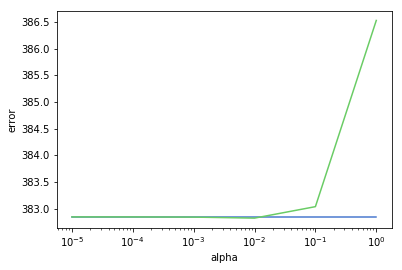

In [14]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

Du fait du nombre de colonnes la régression Ridge est assez longue et on remarque ici qu'elle n'apporte pas d'amélioration notable. 

# Modèles avec mean encoding

## Régression polynomiale

Tentons une nouvelle approche utilisant une régression polynomiale. Pour cela nous devons réduire grandement notre jeu de données : utilisons à cet effet du mean encoding. Supprimons les colonnes FL_NUM, DEST_AIRPORT_ID et ORIGIN_AIRPORT_ID qui comportent trop de valeurs différentes et risqueraient de perturber notre mean encoding.

In [15]:
data = save
data = data.drop(columns=["FL_NUM", "DEST_AIRPORT_ID", "ORIGIN_AIRPORT_ID"], axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(data.loc[:, data.columns != 'ARR_DELAY_NEW'], data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)
train = pd.merge(xtrain, ytrain, right_index=True, left_index=True)

In [16]:
columns = data.loc[:, "MONTH":"DAY_OF_WEEK"].columns
for column in columns:
    items = train.groupby(column).mean()["ARR_DELAY_NEW"].to_dict()
    for key, value in items.items():
        train.loc[train[column] == key, column] = value
        xtest.loc[xtest[column] == key, column] = value

In [17]:
xtrain = train.loc[:, train.columns != "ARR_DELAY_NEW"]
ytrain = train[["ARR_DELAY_NEW"]]

In [18]:
for degree in [2, 3, 4]:
    model = make_pipeline(PolynomialFeatures(degree), linear_model.Ridge())
    model.fit(xtrain, ytrain)
    print("Root Mean Squared Error: %.2f with degree %s"% (math.sqrt(np.mean((model.predict(xtest) - ytest) ** 2)), degree))

Root Mean Squared Error: 21.49 with degree 2
Root Mean Squared Error: 20.89 with degree 3
Root Mean Squared Error: 178.76 with degree 4


Les régressions polynomiales de degré 2 et 3 apportent des résultats  meilleurs. Regardons si l'ajout de alphas ne permet pas d'améliorer nos résultats.

In [19]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
for degree in [2, 3]:
    for alpha in alphas:
        model = make_pipeline(PolynomialFeatures(degree), linear_model.Ridge(alpha=alpha))
        model.fit(xtrain, ytrain)
        print("Root Mean Squared Error: %.2f with degree %s and alpha %s"% (math.sqrt(np.mean((model.predict(xtest) - ytest) ** 2)), degree, alpha))

Root Mean Squared Error: 21.48 with degree 2 and alpha 0.0001
Root Mean Squared Error: 21.48 with degree 2 and alpha 0.001
Root Mean Squared Error: 21.48 with degree 2 and alpha 0.01
Root Mean Squared Error: 21.48 with degree 2 and alpha 0.1
Root Mean Squared Error: 21.49 with degree 2 and alpha 1
Root Mean Squared Error: 20.95 with degree 3 and alpha 0.0001
Root Mean Squared Error: 20.94 with degree 3 and alpha 0.001
Root Mean Squared Error: 20.91 with degree 3 and alpha 0.01
Root Mean Squared Error: 20.89 with degree 3 and alpha 0.1
Root Mean Squared Error: 20.89 with degree 3 and alpha 1


La régression polynomiale de degré 3 avec un alpha de 1 est celle qui nous apporte les meilleurs résultats ici. Regardons si la normalisation des données peut nous aider à améliorer encore cela.

## Normalisation

Nous choisissons ici la normalisation devant la standardisation puisque nous ne voulons que des variables positives.

In [20]:
columns = ["MONTH","DAY_OF_MONTH","DAY_OF_WEEK", "DEP_TIME", "ARR_TIME", "AIR_TIME", "DEP_0_280_TIME", 
           "ARR_0_220_TIME", "AIR_0_360_TIME"]
xtrain, xtest, ytrain ,ytest = train_test_split(data.loc[:, data.columns != 'ARR_DELAY_NEW'], data[["ARR_DELAY_NEW"]],
                                                test_size=0.2, random_state=0)
train = pd.merge(xtrain, ytrain, right_index=True, left_index=True)
min_max_scaler = preprocessing.MinMaxScaler()
train.loc[:, columns] = min_max_scaler.fit_transform(train.loc[:, columns])
xtest.loc[:, columns] = min_max_scaler.transform(xtest.loc[:, columns])
xtrain = train.loc[:, train.columns != "ARR_DELAY_NEW"]
ytrain = train[["ARR_DELAY_NEW"]]

In [21]:
model = make_pipeline(PolynomialFeatures(2), linear_model.Ridge())
model.fit(xtrain, ytrain)
print("Root Mean Squared Error: %.2f"% math.sqrt(np.mean((model.predict(xtest) - ytest) ** 2)))

Root Mean Squared Error: 21.82


In [22]:
model = make_pipeline(PolynomialFeatures(3), linear_model.Ridge())
model.fit(xtrain, ytrain)
print("Root Mean Squared Error: %.2f"% math.sqrt(np.mean((model.predict(xtest) - ytest) ** 2)))

Root Mean Squared Error: 21.53


Les résultats sont légèrement détériorés probablement du fait que la normalisation engendre une perte d'information.

Profitons de notre mean encoding pour tester les régressions Ridge et Lasso. Mettons en place un GridSearchCV poiur la régression Ridge afin de voir si l'on peut améliorer nos résultats.

## Ridge

In [23]:
data = save
data = data.drop(columns=["FL_NUM", "DEST_AIRPORT_ID", "ORIGIN_AIRPORT_ID"], axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(data.loc[:, data.columns != 'ARR_DELAY_NEW'], data[["ARR_DELAY_NEW"]], test_size=0.2, random_state=0)
train = pd.merge(xtrain, ytrain, right_index=True, left_index=True)

columns = data.loc[:, "MONTH":"DAY_OF_WEEK"].columns
for column in columns:
    items = train.groupby(column).mean()["ARR_DELAY_NEW"].to_dict()
    for key, value in items.items():
        train.loc[train[column] == key, column] = value
        xtest.loc[xtest[column] == key, column] = value

xtrain = train.loc[:, train.columns != "ARR_DELAY_NEW"]
ytrain = train[["ARR_DELAY_NEW"]]

In [24]:
grid = GridSearchCV(linear_model.Ridge(), param_grid = {"alpha":alphas}, cv=5)
grid.fit(xtrain, ytrain)
print("Root Mean Squared Error: %.2f"% math.sqrt(np.mean((grid.predict(xtest) - ytest) ** 2)))

Root Mean Squared Error: 21.79


## Lasso

In [25]:
clf = linear_model.Lasso(max_iter=10000, alpha=1)
clf.fit(xtrain, ytrain)
print("Root Mean Squared Error: %.2f"% math.sqrt(np.mean((clf.predict(xtest) - ytest.values) ** 2)))

Root Mean Squared Error: 22.50


La régression Lasso et Ridge ne sont pas plus efficaces.

## Régression Linéaire

Regardons enfin les coefficients de notre regression linéaire pour comprendre les variables influant le plus.

In [26]:
xtrain.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,AIR_TIME,DEP_0_280,ARR_0_220,AIR_0_360,DEP_0_280_TIME,ARR_0_220_TIME,AIR_0_360_TIME
55505,5.133274,6.642723,8.441030,1275,1395,89.0,0,0,1,1275,1395,0.0
60493,5.133274,6.860787,6.291437,454,628,334.0,0,0,1,454,628,0.0
57102,5.133274,7.009374,7.692577,537,690,128.0,0,0,1,537,690,0.0
40725,7.395382,7.998838,7.099756,581,726,304.0,0,0,1,581,726,0.0
64986,7.320927,6.381798,6.365860,450,577,290.0,0,0,1,450,577,0.0


In [27]:
lr = linear_model.LinearRegression()
lr.fit(xtrain, ytrain)
list(lr.coef_[0][0:16])

[0.9305181840783486,
 0.9822538169680912,
 0.9619348988913421,
 0.10800188157890907,
 0.02780199802916028,
 -0.004034534844547744,
 1.088137466047375,
 20.38992463988125,
 183.1976526485182,
 -0.10854080315051817,
 -0.021739465595885576,
 0.5218577074413844]

De nouveau, on remarque l'intérêt de nos variables booléennes qui sont de loin les plus importantes dans la décision finale preuve que le feature engineering était ici primordial. On aurait pu penser à ajouter d'autres colonnes (éloignement des vacances, jour férié...).

Si la régression polynomiale de degrée 3 est l'algorithme apportant les meilleurs résultats avec du mean encoding, elle reste moins efficace que la régression linéaire avec les dummies. En revanche le nombre de colonnes et le temps d'exécution de notre régression polynomiale de degrée 3 sont bien plus intéressants. Il va nous falloir tester ces deux options sur l'ensemble de notre dataset afin de choisir laquelle conserver. Notons que la régression polynomiale de degré 2 n'est pas à éliminer non plus tant son temps d'exécution peut s'avérer positif et ses résultats globalement satisfaisants.

Pour ce faire nous allons créer deux nouveaux notebooks. Le premier nous servira de baseline error et le second sera lui utiliser pour entrainer nos modèles finaux.